# Optimise on a multi scan

In [5]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [21]:
from scipy.optimize import curve_fit

def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov
def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

In [15]:
header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread
Brho = 24*3.3356

In [18]:
quad_current = {
    "QFN01": 620,
    "QDN02": 404,
    "QFN03": 378,
}
quad_length = {
    "QFN01": 0.74,
    "QDN02": 1.2,
    "QFN03": 1.2,
}

In [43]:
# Initial conditions East Area
betx0 = 81.278
bety0 = 3.024
alfx0 = -19.03
alfy0 = 1.889
dx0 = -7.708
dy0 = -1.981
dpx0 = -1.938
dpy0 = -0.01
exn = 1.463e-06
eyn = 1.499e-06
sige = 0.000761115

In [39]:
# Second try initial conditions East Area
betx0 = 8.11835338e+01
bety0 = 1.28878920e+00
alfx0 = -1.29936667e+01
alfy0 = 1.19136919e+00
dx0 = -6.79696824e+00
dy0 = -1.68634936e+00
dpx0 = -1.70764691e+00
dpy0 = 2.40179014e-01
exn = 2.61635898e-08
eyn = 1.44531164e-06
sige = 7.53503591e-04

# Create dataframe with measurements

In [24]:
filename_list = ["quad_scan_east_dump_2022_04_11_13h17m30s","quad_scan_east_dump_2022_04_11_13h47m05s", "quad_scan_east_dump_2022_04_11_14h28m24s", "quad_scan_east_dump_2022_04_11_14h44m15s", "quad_scan_east_dump_2022_04_11_15h03m36s"]

measurement_df = pd.DataFrame(columns = ['H_sigma', 'H_sigma_err', 'V_sigma', 'V_sigma_err', 'qfn01_current', 'qdn02_current', 'qfn03_current'])

for i in range(len(filename_list)):
    start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
    end_path = "quad_scan_east_dump_data"
    filename = filename_list[i]
    
    infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
    loaded_pickle = pickle.load(infile)
    
    acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
    qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
    qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

    if (filename == filename_list[1]):
        acquisition = acquisition[:len(acquisition)-15]
        qfn01_current = qfn01_current[:len(qfn01_current)-15]
        qdn02_current = qdn02_current[:len(qdn02_current)-15]
        qfn03_current = qfn03_current[:len(qfn03_current)-15]
    
    if (filename == filename_list[2]):
        acquisition = acquisition[:len(acquisition)-1]
        qfn01_current = qfn01_current[:len(qfn01_current)-1]
        qdn02_current = qdn02_current[:len(qdn02_current)-1]
        qfn03_current = qfn03_current[:len(qfn03_current)-1]
    
    if (filename == filename_list[4]):
        acquisition = acquisition[:len(acquisition)-8]
        qfn01_current = qfn01_current[:len(qfn01_current)-8]
        qdn02_current = qdn02_current[:len(qdn02_current)-8]
        qfn03_current = qfn03_current[:len(qfn03_current)-8]
    
    acq_number = 4

    H_sigma_list_i = []
    H_err_sigma_list_i = []
    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)

        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)

    intermediate_df = pd.DataFrame(data = {"H_sigma": [H_sigma_list_i],
                                          "H_sigma_err": [H_err_sigma_list_i],
                                          "V_sigma": [V_sigma_list_i],
                                          "V_sigma_err": [V_err_sigma_list_i],
                                          "qfn01_current": [qfn01_current],
                                          "qdn02_current": [qdn02_current],
                                          "qfn03_current": [qfn03_current]})
    measurement_df = pd.concat([measurement_df, intermediate_df]).reset_index(drop=True)

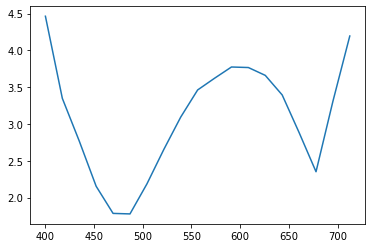

In [25]:
fig, ax = plt.subplots()
ax.plot(measurement_df.qfn01_current[0], measurement_df.H_sigma[0])

In [44]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)


madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

H_sigma_madx = []
V_sigma_madx = []

for i in range(len(measurement_df.qfn01_current[0])):
    quad_current["QFN01"] = measurement_df.qfn01_current[0][i]
    quad_current["QDN02"] = measurement_df.qdn02_current[0][i]
    quad_current["QFN03"] = measurement_df.qfn03_current[0][i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )


In [45]:
fig, ax = plt.subplots()
ax.plot(measurement_df.qfn01_current[0], measurement_df.H_sigma[0])
ax.plot(measurement_df.qfn01_current[0], np.array(H_sigma_madx)*1000)

In [41]:
fig, ax = plt.subplots()
ax.plot(measurement_df.qfn01_current[0], measurement_df.H_sigma[0])
ax.plot(measurement_df.qfn01_current[0], np.array(H_sigma_madx)*1000)

In [38]:
# Py-BOBYQA example: minimize the Rosenbrock function
from __future__ import print_function
import pybobyqa

exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


# Define the objective function
def f_fit(params):
    print(params)
    betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn, sige = params

    
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)
    

    madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

    madx.input('SEQEDIT, SEQUENCE=f61d;')
    madx.input('FLATTEN;')
    madx.input('REMOVE, ELEMENT=ARBMATRIX;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    
    
    H_sigma_madx = []
    V_sigma_madx = []

    for i in range(len(measurement_df.qfn01_current[0])):
        quad_current["QFN01"] = measurement_df.qfn01_current[0][i]
        quad_current["QDN02"] = measurement_df.qdn02_current[0][i]
        quad_current["QFN03"] = measurement_df.qfn03_current[0][i]

        madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

        madx.use(sequence="f61d")
        twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

        H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
        V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

    deltaH = abs(measurement_df.H_sigma[0] - np.array(H_sigma_madx)*1000)**2
    deltaV = abs(measurement_df.V_sigma[0] - np.array(V_sigma_madx)*1000)**2
    
    objective = sum(deltaH) + sum(deltaV)
        
    print (objective)
    return (objective)

# Define the starting point
initial_guess = [8.10320374e+01, 1.75850966e+00, -1.24235188e+01, 1.38448554e+00, -4.89293824e+00, -9.90627329e-01, -1.26489793e+00, -3.91133201e-02, 1.49710514e-06, 1.48850811e-06, 7.50894919e-04]

# Define bound constraints (lower <= x <= upper)
lower = np.array([1, 1, -100, -100, -100, -100, -100, -100, 0.0, 0.0, 0.1e-4])
upper = np.array([150, 150, 100, 100, 100, 100, 100, 100, 5.0e-6, 5.0e-6, 20.0e-4])


# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=False, scaling_within_bounds=True, rhoend=1e-6)

# Display output
print(soln)

[ 8.10320374e+01  1.75850966e+00 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
68.36354252552563
[ 1.50000000e+02  1.75850966e+00 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
628.0516914290151
[ 8.10320374e+01  7.62585097e+01 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
682.7353904921277
[ 8.10320374e+01  1.75850966e+00  8.75764812e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
36388.41323485739
[ 8.10320374e+01  1.75850966e+00 -1.24235188e+01  1.00000000e+02
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
3868432.8744287286
[ 8.10320

41398.424599449296
[ 8.19894795e+01  7.97972422e+00 -1.40900028e+01 -9.08458001e-01
 -4.04046086e+00  4.56576240e-02 -9.91474437e-01  2.13756803e-01
  3.25399813e-08  1.58056168e-06  7.32577578e-04]
88.33927826647263
[ 8.10460153e+01  1.73246667e+00 -1.24474514e+01  1.29023481e+00
 -4.80681635e+00 -9.88982729e-01 -1.07723753e+01 -4.21022422e-02
  7.73841547e-08  1.48938345e-06  7.51721262e-04]
240388.1747678452
[ 8.37844780e+01  2.99058131e+00 -1.08294260e+01 -3.27348072e-01
 -5.48281955e+00 -4.58001340e-01 -1.25935855e+00  1.59213305e-01
  0.00000000e+00  1.34970318e-06  6.82938631e-04]
247.22116041630693
[ 7.99382527e+01  2.59024902e+00 -1.26846953e+01 -1.61587807e-01
 -6.67123347e+00  4.25152013e-01 -1.04483206e+00  2.42735434e-01
  0.00000000e+00  1.57635738e-06  7.38721334e-04]
593.4197782738629
[ 8.10017245e+01  1.54359994e+00 -1.24485434e+01  1.63512140e+00
 -4.96194195e+00 -1.00068228e+00 -8.17576862e-01 -5.62186527e-02
  6.07016799e-08  1.48805704e-06  7.50651587e-04]
283.3541

53.560562009575975
[ 8.13029085e+01  1.73464069e+00 -1.25459087e+01  1.55020278e+00
 -4.63099459e+00 -1.13983667e+00 -1.14473258e+00  1.04109323e-01
  1.55155708e-09  1.47219155e-06  7.55976923e-04]
52.820922673767775
[ 8.12972306e+01  1.74236834e+00 -1.25424247e+01  1.54685278e+00
 -4.62541668e+00 -1.14335138e+00 -1.13908166e+00  9.68912993e-02
  1.46359176e-09  1.47237701e-06  7.55822442e-04]
53.16713772479229
[ 8.13018703e+01  1.73450137e+00 -1.25409738e+01  1.54827862e+00
 -4.63553452e+00 -1.14190956e+00 -1.14567542e+00  1.04245185e-01
  1.52145187e-09  1.47203812e-06  7.55954588e-04]
52.73049761978068
[ 8.13019291e+01  1.73459471e+00 -1.25385577e+01  1.55011876e+00
 -4.63041455e+00 -1.14391104e+00 -1.14282439e+00  1.01336363e-01
  1.55732359e-09  1.47189720e-06  7.55986227e-04]
52.78600134465993
[ 8.13039048e+01  1.73245207e+00 -1.25450785e+01  1.54542482e+00
 -4.63670008e+00 -1.13642393e+00 -1.14427933e+00  1.00757170e-01
  1.55617708e-09  1.47201878e-06  7.55920279e-04]
52.97917

40.0668221924605
[ 8.20940567e+01  1.92246804e+00 -1.27886534e+01  1.19133892e+00
 -4.73655086e+00 -1.96320915e+00 -1.40039071e+00  1.57646017e-01
  0.00000000e+00  1.47755236e-06  7.63778927e-04]
80.8598315530468
[ 8.14893024e+01  1.75855450e+00 -1.28441736e+01  1.42805022e+00
 -4.92935352e+00 -1.59885312e+00 -1.29413821e+00  1.98566625e-01
  2.87659656e-09  1.46824342e-06  7.58662642e-04]
44.13133618255492
[ 8.13276441e+01  1.43358827e+00 -1.31112653e+01  1.36964521e+00
 -5.17027488e+00 -1.54033415e+00 -1.25018371e+00  1.85899868e-01
  1.08935100e-08  1.46412301e-06  7.56589160e-04]
41.759596620575635
[ 8.14208990e+01  1.71486546e+00 -1.28584817e+01  1.37903481e+00
 -4.96248015e+00 -1.56026755e+00 -1.30756606e+00  2.00304105e-01
  3.32636539e-09  1.46666617e-06  7.58396552e-04]
46.31081102918362
[ 8.14758958e+01  1.79187297e+00 -1.27321889e+01  1.42263268e+00
 -5.17419257e+00 -1.66923099e+00 -1.31435471e+00  2.06566767e-01
  0.00000000e+00  1.46530140e-06  7.58657252e-04]
39.07229526

32.79868385803862
[ 8.13733459e+01  1.51205494e+00 -1.32089168e+01  1.28471221e+00
 -5.58198849e+00 -1.87825645e+00 -1.40410413e+00  2.59330662e-01
  9.56661841e-09  1.45742927e-06  7.58080516e-04]
32.734433618904106
[ 8.13684137e+01  1.51055398e+00 -1.32090981e+01  1.28538548e+00
 -5.58283492e+00 -1.87383919e+00 -1.40545033e+00  2.59221844e-01
  9.64544155e-09  1.45736263e-06  7.58045303e-04]
32.65118902623088
[ 8.13513892e+01  1.49947432e+00 -1.32115665e+01  1.28666471e+00
 -5.58800446e+00 -1.85512332e+00 -1.40559956e+00  2.54342892e-01
  9.97222836e-09  1.45704353e-06  7.57938937e-04]
32.256381075902276
[ 8.13366530e+01  1.48420606e+00 -1.32133411e+01  1.29017979e+00
 -5.59578502e+00 -1.83553158e+00 -1.40475466e+00  2.51449542e-01
  1.03385401e-08  1.45680061e-06  7.57906462e-04]
31.918708135990208
[ 8.13187611e+01  1.48691975e+00 -1.32188725e+01  1.28755346e+00
 -5.58899067e+00 -1.81723602e+00 -1.39978134e+00  2.46211511e-01
  1.05338912e-08  1.45629486e-06  7.57823750e-04]
31.8479

30.149757746954155
[ 8.12625670e+01  1.44559452e+00 -1.31713174e+01  1.25952985e+00
 -5.68777999e+00 -1.63731584e+00 -1.42800690e+00  1.91868652e-01
  1.19671872e-08  1.45530483e-06  7.57068321e-04]
30.311422476884893
[ 8.12581673e+01  1.44919474e+00 -1.31752178e+01  1.25750083e+00
 -5.69290310e+00 -1.64110185e+00 -1.43254141e+00  2.04775247e-01
  1.19174873e-08  1.45508023e-06  7.57089926e-04]
29.99235425248737
[ 8.12365630e+01  1.44609493e+00 -1.31769673e+01  1.24490992e+00
 -5.73723144e+00 -1.63063867e+00 -1.45504000e+00  2.01095346e-01
  1.23720049e-08  1.45415778e-06  7.56760829e-04]
29.746051732595717
[ 8.12536371e+01  1.41587373e+00 -1.31681770e+01  1.22069857e+00
 -5.76321523e+00 -1.61844094e+00 -1.44872564e+00  1.91174204e-01
  1.33233795e-08  1.45417049e-06  7.56422666e-04]
29.462726175762917
[ 8.12691526e+01  1.38423765e+00 -1.31820792e+01  1.20188871e+00
 -5.78407043e+00 -1.64635284e+00 -1.43560666e+00  1.93747312e-01
  1.42856396e-08  1.45455021e-06  7.56197745e-04]
30.036

26.75596939727041
[ 8.11134556e+01  1.35329772e+00 -1.30877525e+01  1.03697329e+00
 -6.32125283e+00 -1.62295629e+00 -1.59358294e+00  1.70256216e-01
  1.84405632e-08  1.44833410e-06  7.54346605e-04]
26.63588463882999
[ 8.11072519e+01  1.35897238e+00 -1.30860921e+01  1.05001457e+00
 -6.33728166e+00 -1.61861657e+00 -1.59602705e+00  1.71577957e-01
  1.86352687e-08  1.44845630e-06  7.54417555e-04]
26.520878201379894
[ 8.11080124e+01  1.35862780e+00 -1.30876320e+01  1.04548919e+00
 -6.33276661e+00 -1.61545740e+00 -1.59124327e+00  1.68097773e-01
  1.85425483e-08  1.44852683e-06  7.54509367e-04]
26.574091801827883
[ 8.11094492e+01  1.35613878e+00 -1.30901522e+01  1.05241251e+00
 -6.33180062e+00 -1.62398631e+00 -1.59415063e+00  1.72885822e-01
  1.86346263e-08  1.44845663e-06  7.54503497e-04]
26.445248242311813
[ 8.11057432e+01  1.35363057e+00 -1.30905712e+01  1.05790070e+00
 -6.32979008e+00 -1.62468118e+00 -1.59452608e+00  1.72086911e-01
  1.85532938e-08  1.44835670e-06  7.54490300e-04]
26.3623

24.90240353275557
[ 8.11518457e+01  1.30402881e+00 -1.30264576e+01  1.16380876e+00
 -6.49984730e+00 -1.71560919e+00 -1.63917332e+00  2.31770099e-01
  1.99092639e-08  1.44792278e-06  7.53919554e-04]
24.816318295690767
[ 8.12005187e+01  1.26523335e+00 -1.30283641e+01  1.25802633e+00
 -6.53345516e+00 -1.74903551e+00 -1.65542836e+00  2.69066803e-01
  2.13873727e-08  1.44777776e-06  7.53441554e-04]
25.926209825784277
[ 8.11498240e+01  1.30412164e+00 -1.29905295e+01  1.16556532e+00
 -6.50589914e+00 -1.67570068e+00 -1.62844222e+00  2.32388257e-01
  1.98778996e-08  1.44882420e-06  7.53468808e-04]
24.919082492712754
[ 8.11549827e+01  1.30094231e+00 -1.30317831e+01  1.17063680e+00
 -6.49661072e+00 -1.72545785e+00 -1.63953255e+00  2.33586040e-01
  1.99782248e-08  1.44785847e-06  7.53873960e-04]
24.89961378287718
[ 8.11535401e+01  1.30201784e+00 -1.30026763e+01  1.16583033e+00
 -6.52533017e+00 -1.69952362e+00 -1.64423802e+00  2.34347582e-01
  2.00347789e-08  1.44799923e-06  7.53854357e-04]
24.6873

24.86526158720288
[ 8.11595836e+01  1.30365066e+00 -1.29897769e+01  1.12954295e+00
 -6.65964295e+00 -1.65987991e+00 -1.66581889e+00  2.03718035e-01
  2.28634724e-08  1.44620096e-06  7.53766585e-04]
24.441133162468592
[ 8.11683320e+01  1.28035047e+00 -1.29700558e+01  1.19254228e+00
 -6.63990090e+00 -1.68674460e+00 -1.66767470e+00  2.34704339e-01
  2.22208276e-08  1.44671702e-06  7.53677671e-04]
24.326995460142662
[ 8.11803776e+01  1.27843190e+00 -1.29757493e+01  1.17953254e+00
 -6.65841237e+00 -1.67529178e+00 -1.67358085e+00  2.31267142e-01
  2.29923060e-08  1.44668425e-06  7.53633838e-04]
24.13901885464824
[ 8.11737385e+01  1.28202261e+00 -1.29878725e+01  1.17360458e+00
 -6.68123751e+00 -1.66383188e+00 -1.68378457e+00  2.27903625e-01
  2.32631267e-08  1.44595330e-06  7.53681856e-04]
24.06463241978819
[ 8.11962858e+01  1.28280590e+00 -1.30192392e+01  1.14517732e+00
 -6.75614828e+00 -1.65497329e+00 -1.70574781e+00  2.05220311e-01
  2.56248356e-08  1.44428584e-06  7.54087068e-04]
24.21268

23.807062590617065
[ 8.11797442e+01  1.28152854e+00 -1.30036860e+01  1.17576267e+00
 -6.76862578e+00 -1.66088049e+00 -1.70647049e+00  2.26230143e-01
  2.51274575e-08  1.44508244e-06  7.53459765e-04]
23.856476680129287
[ 8.11801312e+01  1.28062755e+00 -1.30090433e+01  1.17570649e+00
 -6.76806740e+00 -1.66329336e+00 -1.70062757e+00  2.29747295e-01
  2.51465299e-08  1.44501620e-06  7.53446130e-04]
23.799883167930247
[ 8.11811352e+01  1.28064792e+00 -1.30051096e+01  1.17622025e+00
 -6.76898389e+00 -1.66561765e+00 -1.70019944e+00  2.31923173e-01
  2.51300161e-08  1.44505282e-06  7.53454474e-04]
23.792902844532353
[ 8.11800774e+01  1.28089499e+00 -1.30033276e+01  1.17681842e+00
 -6.77089364e+00 -1.66615797e+00 -1.70172035e+00  2.32485021e-01
  2.52076455e-08  1.44503042e-06  7.53424086e-04]
23.778297568801477
[ 8.11809756e+01  1.28020535e+00 -1.30015617e+01  1.17991708e+00
 -6.77339590e+00 -1.66711511e+00 -1.70343351e+00  2.33426919e-01
  2.52682647e-08  1.44503690e-06  7.53425613e-04]
23.77

KeyboardInterrupt: 